<a href="https://colab.research.google.com/github/tonilynnegibson/tonilynnegibson.github.io/blob/main/Seoul_Bike_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Demand Forecasting for Bike Rentals in Seoul**

Created by Toni Gibson

### I predicted bike rental demand by modeling the number of bikes rented based on weather and time-related features. I used the Seoul Bike Sharing dataset available through Hugging Face. To build the prediction model, I used PyTorch to set up and train a regression neural network. I evaluated performance using standard regression metrics (MSE, MAE, R²) to measure both average prediction error and overall fit. In a real business setting, these predictions could be used to forecast daily or hourly demand, helping teams plan staffing needs, schedule bike rebalancing and replenishment, and reduce shortages or oversupply at stations during peak and low-demand periods.

rows (raw): 8760
columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
sample row (raw): {'Date': '01/12/2017', 'Rented Bike Count': 254, 'Hour': 0, 'Temperature(°C)': -5.2, 'Humidity(%)': 37, 'Wind speed (m/s)': 2.2, 'Visibility (10m)': 2000, 'Dew point temperature(°C)': -17.6, 'Solar Radiation (MJ/m2)': 0.0, 'Rainfall(mm)': 0.0, 'Snowfall (cm)': 0.0, 'Seasons': 'Winter', 'Holiday': 'No Holiday', 'Functioning Day': 'Yes'}


Filter:   0%|          | 0/8760 [00:00<?, ? examples/s]

rows after filtering (Yes): 8465
sample filtered row: {'Date': '01/12/2017', 'Rented Bike Count': 254, 'Hour': 0, 'Temperature(°C)': -5.2, 'Humidity(%)': 37, 'Wind speed (m/s)': 2.2, 'Visibility (10m)': 2000, 'Dew point temperature(°C)': -17.6, 'Solar Radiation (MJ/m2)': 0.0, 'Rainfall(mm)': 0.0, 'Snowfall (cm)': 0.0, 'Seasons': 'Winter', 'Holiday': 'No Holiday', 'Functioning Day': 'Yes'}
x shape: torch.Size([8465, 5])
y_tensor shape: torch.Size([8465, 1])
normalized_x shape: torch.Size([8465, 5])
normalized_x sample row: tensor([-1.6626, -1.4847, -1.0323,  0.4584, -0.1325])
number of batches: 133
x_batch shape: torch.Size([64, 5])
y_batch shape: torch.Size([64, 1])
BikeModel(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
device: cuda
SGD epoch 10 average loss: 380432.12629229325
SGD epoch 20 avera

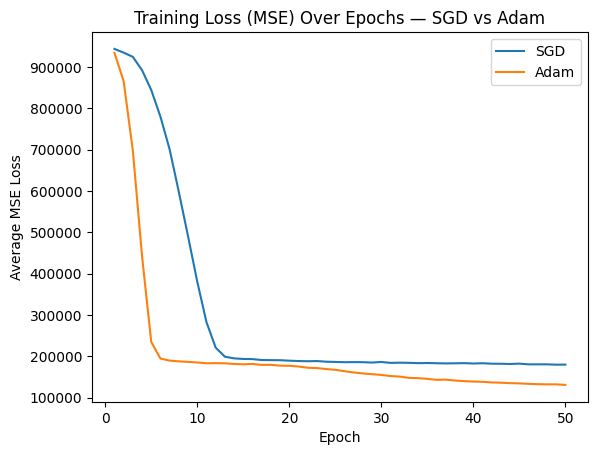

Adam converged faster and achieved a lower final training loss than SGD over 50 epochs.
MSE: 130536.953125
MAE: 250.1055450439453
R2: 0.6835975646972656
predicted rented bike count for each scenario:
scenario 1 prediction: 721.5758056640625
scenario 2 prediction: 163.86892700195312
scenario 3 prediction: 13.853431701660156


In [2]:


#Data Preparation

#Load the dataset using: load_dataset("ejjang/Seoul_bike")
!pip install datasets --quiet
from datasets import load_dataset
dataset = load_dataset("ejjang/Seoul_bike")
data = dataset["train"]

print("rows (raw):", len(data))
print("columns:", data.column_names)
print("sample row (raw):", data[0])

#Choose some numerical features

features = ["Hour", "Temperature(°C)", "Humidity(%)",
            "Wind speed (m/s)", "Rainfall(mm)"]

#Filter to only include rows where "Functioning Day" equals "Yes"

def yes_functioning(row):
  return row["Functioning Day"] == "Yes"

functioning_filter = data.filter(yes_functioning)

print("rows after filtering (Yes):", len(functioning_filter))
print("sample filtered row:", functioning_filter[0])

#Target variable: Rented Bike Count

import numpy as np
target_var = "Rented Bike Count"
y = np.array(functioning_filter[target_var], dtype=np.float32)

#Convert data to PyTorch tensors (float32)

import torch
x = torch.tensor(np.array([[row[col] for col in features]
  for row in functioning_filter], dtype=np.float32),dtype=torch.float32)

y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

print("x shape:", x.shape)
print("y_tensor shape:", y_tensor.shape)

#Normalize all numerical features

x_mean = x.mean(dim=0)
x_std = x.std(dim=0)
eps = 1e-8

normalized_x = (x - x_mean)/ (x_std + eps)

print("normalized_x shape:", normalized_x.shape)
print("normalized_x sample row:", normalized_x[0])

#Create a DataLoader

from torch.utils.data import DataLoader, TensorDataset

tensor_dataset = TensorDataset(normalized_x, y_tensor)

loader = DataLoader(tensor_dataset, batch_size=64, shuffle=True)

print("number of batches:", len(loader))
for x_batch, y_batch in loader:
  break
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

#Model Architecture

import torch.nn as nn

input_size = len(features)

class BikeModel(nn.Module):
  def __init__(self,input_size):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(input_size, 64),nn.ReLU(),
        nn.Linear(64,32),nn.ReLU(),
        nn.Linear(32,1))

  def forward(self, x):
        return self.net(x)

model = BikeModel(input_size)
print(model)


#Training Loop

train_losses = []

loss_fn = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def train_model(optimizer_name,lr,epochs=50):
  model = BikeModel(input_size).to(device)

  if optimizer_name == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  elif optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  else:
    raise ValueError("optimizer_name must be SGD or Adam")

  losses = []

  for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for x_batch, y_batch in loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      predictions = model(x_batch)
      loss = loss_fn(predictions, y_batch)

      optimizer.zero_grad()
      loss.backward()
      #helps prevent exploding gradients (SGD was nan without this)
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()

      epoch_loss += loss.item()

    average_loss = epoch_loss / len(loader)
    losses.append(average_loss)

    if (epoch + 1) % 10 == 0:
      print(optimizer_name, "epoch", epoch + 1, "average loss:", average_loss)

  return model, losses

sgd_model, sgd_losses = train_model("SGD", lr=0.01, epochs=50)
adam_model, adam_losses = train_model("Adam", lr=0.001, epochs=50)

print("final SGD loss:", sgd_losses[-1])
print("final Adam loss:", adam_losses[-1])

# create a plot

import matplotlib.pyplot as plt

epochs = range(1, len(adam_losses) + 1)

plt.figure()
plt.plot(epochs, sgd_losses, label="SGD")
plt.plot(epochs, adam_losses, label="Adam")
plt.title("Training Loss (MSE) Over Epochs — SGD vs Adam")
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.legend()
plt.show()

# Adam converged faster and achieved a lower
#final training loss than SGD over 50 epochs.

print("Adam converged faster and achieved a lower final training loss than SGD over 50 epochs.")


#Evaluation and Prediction Using Best Model: Adam

adam_model.eval()

with torch.no_grad():
  x_all = normalized_x.to(device)
  y_all = y_tensor.to(device)

  preds = adam_model(x_all)

  mse = torch.mean((preds - y_all) ** 2)
  mae = torch.mean(torch.abs(preds - y_all))

  ss_res = torch.sum((y_all - preds) ** 2)
  ss_tot = torch.sum((y_all - torch.mean(y_all)) ** 2)
  r2 = 1 - (ss_res / ss_tot)

print("MSE:", mse.item())
print("MAE:", mae.item())
print("R2:", r2.item())


# on average, the model’s predictions are off by
# about 292 bikes per hour (MAE), and the model explains about
# 57.5% of the variation in hourly bike demand
# based on the selected features.

# scenario predictions

adam_model.eval()

scenarios = [
    # features = ["Hour", "Temperature(°C)", "Humidity(%)",
    #        "Wind speed (m/s)", "Rainfall(mm)"]
    [8, 25, 35, 2.0, 0.0],   # Summer morning rush hour
    [18, -5, 55, 2.0, 0.0],  # Winter evening
    [15, 15, 85, 2.0, 5.0]   # Rainy spring afternoon
    ]

scenarios_tensor = torch.tensor(scenarios, dtype=torch.float32)
# normalize
scenarios_norm = (scenarios_tensor - x_mean) / (x_std + eps)

with torch.no_grad():
  preds = adam_model(scenarios_norm.to(device)).cpu().numpy()

print("predicted rented bike count for each scenario:")
for i, p in enumerate(preds, start=1):
    print("scenario", i, "prediction:", float(p[0]))

# Scenarios:
# scenario 1: Summer morning rush hour
# - Demand is highest during the morning commute window,
# and warm, dry weather supports higher ridership.

# scenario 2: Winter evening
# - Demand is much lower because very cold temperatures,
# even though it’s still a commute time.

# scenario 3: Rainy spring afternoon
# - Rainfall strongly suppresses ridership,
# so the model predicts extremely low demand despite
# moderate temperatures. Bike-sharing operations should reduce
# rebalancing and staffing expectations during rainy periods.


**Key Takeaway**

###Adam trained more efficiently than SGD and produced lower loss over 50 epochs. The model captures meaningful relationships between weather/time conditions and bike rental demand, and the scenario forecasts show how demand can swing from high (warm, dry commute hours) to very low (cold/rainy conditions). Metrics (MSE/MAE/R²) vary slightly between runs due to randomness in training.